In [1]:
# Adapted from: https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl
# Function approximation using Q Learning
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid,print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1
SA2IDX = {}
IDX = 0

In [2]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [3]:
def random_action(a, eps=0.1):
  # epsilon-soft to ensure all states are visited
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [4]:
class Model:
  def __init__(self):
    self.theta = np.random.randn(25) / np.sqrt(25)
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # print "D:", IDX
    # self.theta = np.random.randn(IDX) / np.sqrt(IDX)

  def sa2x(self, s, a):
    # NOTE: using just (r, c, r*c, u, d, l, r, 1) is not expressive enough
    return np.array([
      s[0] - 1              if a == 'U' else 0,
      s[1] - 1.5            if a == 'U' else 0,
      (s[0]*s[1] - 3)/3     if a == 'U' else 0,
      (s[0]*s[0] - 2)/2     if a == 'U' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'U' else 0,
      1                     if a == 'U' else 0,
      s[0] - 1              if a == 'D' else 0,
      s[1] - 1.5            if a == 'D' else 0,
      (s[0]*s[1] - 3)/3     if a == 'D' else 0,
      (s[0]*s[0] - 2)/2     if a == 'D' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'D' else 0,
      1                     if a == 'D' else 0,
      s[0] - 1              if a == 'L' else 0,
      s[1] - 1.5            if a == 'L' else 0,
      (s[0]*s[1] - 3)/3     if a == 'L' else 0,
      (s[0]*s[0] - 2)/2     if a == 'L' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'L' else 0,
      1                     if a == 'L' else 0,
      s[0] - 1              if a == 'R' else 0,
      s[1] - 1.5            if a == 'R' else 0,
      (s[0]*s[1] - 3)/3     if a == 'R' else 0,
      (s[0]*s[0] - 2)/2     if a == 'R' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'R' else 0,
      1                     if a == 'R' else 0,
      1
    ])
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # x = np.zeros(len(self.theta))
    # idx = SA2IDX[s][a]
    # x[idx] = 1
    # return x

  def predict(self, s, a):
    x = self.sa2x(s, a)
    return self.theta.dot(x)

  def grad(self, s, a):
    return self.sa2x(s, a)

In [5]:
def getQs(model, s):
  # we need Q(s,a) to choose an action
  # i.e. a = argmax[a]{ Q(s,a) }
  Qs = {}
  for a in ALL_POSSIBLE_ACTIONS:
    q_sa = model.predict(s, a)
    Qs[a] = q_sa
  return Qs

In [6]:
grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [7]:
# no policy initialization, policy is derived from most recent Q
# enumerate all (s,a) pairs, each will have its own weight in our "dumb" model
# essentially each weight will be a measure of Q(s,a) itself
states = grid.all_states()
for s in states:
  SA2IDX[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    SA2IDX[s][a] = IDX
    IDX += 1

print(SA2IDX)

{(0, 1): {'D': 1, 'U': 0, 'L': 2, 'R': 3}, (1, 2): {'D': 5, 'U': 4, 'L': 6, 'R': 7}, (0, 0): {'D': 9, 'U': 8, 'L': 10, 'R': 11}, (2, 3): {'D': 25, 'U': 24, 'L': 26, 'R': 27}, (2, 0): {'D': 21, 'U': 20, 'L': 22, 'R': 23}, (1, 3): {'D': 13, 'U': 12, 'L': 14, 'R': 15}, (1, 0): {'D': 33, 'U': 32, 'L': 34, 'R': 35}, (2, 2): {'D': 29, 'U': 28, 'L': 30, 'R': 31}, (0, 3): {'D': 41, 'U': 40, 'L': 42, 'R': 43}, (0, 2): {'D': 37, 'U': 36, 'L': 38, 'R': 39}, (2, 1): {'D': 17, 'U': 16, 'L': 18, 'R': 19}}


In [8]:
# initialize model
model = Model()

In [9]:
# repeat until convergence
t = 1.0
t2 = 1.0
deltas = []
for it in range(20000):
  if it % 100 == 0:
    t += 0.01
    t2 += 0.01
  if it % 1000 == 0:
    print("iteration:", it)
  alpha = ALPHA / t2

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s = (2, 0) # start state
  grid.set_state(s)

  # get Q(s) so we can choose the first action
  Qs = getQs(model, s)

  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  a = max_dict(Qs)[0]
  a = random_action(a, eps=0.5/t) # epsilon-greedy
  biggest_change = 0
  while not grid.game_over():
    r = grid.move(a)
    s2 = grid.current_state()

    # we need the next action as well since Q(s,a) depends on Q(s',a')
    # if s2 not in policy then it's a terminal state, all Q are 0
    old_theta = model.theta.copy()
    if grid.is_terminal(s2):
      model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
    else:
      # not terminal
      Qs2 = getQs(model, s2)
      a2, maxQs2a2 = max_dict(Qs2)
      a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

      # we will update Q(s,a) AS we experience the episode
      model.theta += alpha*(r + GAMMA*maxQs2a2 - model.predict(s, a))*model.grad(s, a)
      
      # next state becomes current state
      s = s2
      a = a2

    biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
  deltas.append(biggest_change)

iteration: 0


iteration: 1000


iteration: 2000


iteration: 3000


iteration: 4000


iteration: 5000


iteration: 6000


iteration: 7000


iteration: 8000


iteration: 9000


iteration: 10000


iteration: 11000


iteration: 12000


iteration: 13000


iteration: 14000


iteration: 15000


iteration: 16000


iteration: 17000


iteration: 18000


iteration: 19000


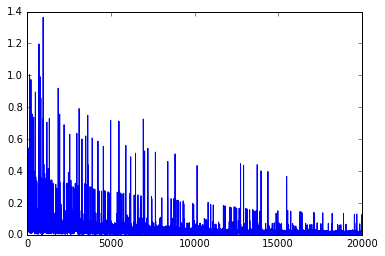

In [10]:
plt.plot(deltas)
plt.show()

In [11]:
# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
Q = {}
for s in grid.actions.keys():
  Qs = getQs(model, s)
  Q[s] = Qs
  a, max_q = max_dict(Qs)
  policy[s] = a
  V[s] = max_q

In [13]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.61| 0.79| 0.99| 0.00|
---------------------------
 0.45| 0.00| 0.64| 0.00|
---------------------------
 0.30| 0.14| 0.18| 0.41|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  U  |  U  |  U  |
